# Contents <a id='top'></a>

1. <a href=#eda>Data Exploration</a>
1. <a href=#sup>Supervised Learning</a>
1. <a href=#skl>sklearn</a>
1. <a href=#metrics>Classification Error Metrics</a>
1. <a href=#app>Application</a>
    1. <a href=#knn>k-Nearest Neighbours</a>
    1. <a href=#hyper>Hyperparameter Search</a>
1. <a href=#ref>References and Links</a>

<a id='eda'></a>
# 1. Introduction to Lending Club Data
<a href=#top>(back to top)</a>

The data set we will be using comes from the Lending Club. It is a peer-to-peer lending company. It offers loans that are funded by other people: 

* A borrower applies for a loan of a certain amount.
* The company assesses the risk of lending. 
* Even if an application is accepted, the requested loan might not be fully funded by investors.

The full dataset can be obtained from the [Kaggle website](https://www.kaggle.com/wordsforthewise/lending-club). It is approximately 650MB in size. However, for our session, we are only going to work with a partial dataset, from 2007 to 2011. It is available on LumiNUS as `loans.xlsx`.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
loans = pd.read_excel('../data/loans.xlsx', index_col=0)

In [7]:
loans[['loan_amnt', 'funded_amnt_inv', 'y']].head()

,loan_amnt,funded_amnt_inv,y
0,5000,4975.0,0
1,2500,2500.0,0
2,2400,2400.0,0
3,10000,10000.0,0
4,3000,3000.0,0


Our version of the loans dataset consists of 42,535 rows and 76 columns. The Kaggle site contains a data dictionary that explains what each column means. Our target variable is contained in the column `y`: we wish to predict it using the remaining columns. 

It was computed from the existing columns as follows. First, for each loan (i.e. row), we compute the proportion of loan not funded:

$$
\text{prop. not funded} = \frac{(\text{loan amnt}) - (\text{funded amnt inv})}{\text{loan amnt}}
$$

Our target variable takes on the value 1 if the proportion not funded is larger than 0.05:

$$
y = \begin{cases}
1 & \text{if prop. not funded} \ge 0.05 \\
0 & \text{otherwise}
\end{cases}
$$

In [8]:
loans.y.mean()

0.1856588691665687

As we see, only about 19% of the loans were unsuccessful. This indicates a moderately unbalanced dataset, and serves as our benchmark. If we were to always predict that a loan is successful (y=0), then we would be correct approximately 81% of the time.

> *Can we do better than this?*

<a id='sup'></a>
# 2. Supervised Learning
<a href=#top>(back to top)</a>

In supervised learning, our goal is to develop a model that can predict a quantity of interest from a set of features. In this process,

* Algorithms learn from a training set of labelled examples.
* This training set is meant to be representative of the set of all possible inputs.
* Example algorithms include logistic regression, support vector machines, decision trees and random forests.

Here are some examples:

1. We wish to predict if a student will graduate from university or not, based on his/her 'A' level results.
2. We wish to predict tomorrow's stock price based on today's price.

The other main sort of learning is unsupervised learning. Here are some examples:

1. We wish to identify the salient topics from a set of English documents.
2. We wish to estimate the probability density function that a sample of observations came from.

In our class, we shall focus only on *supervised* learning.

## Classification versus Regression

If the answer to the question (supervised learning problem) we are facing is either YES or NO, then we have a **classification** problem.

* Given the results of a clinical test, does this patient suffer from diabetes?
* Given an MRI, is there a tumor?

On the other hand, if we are trying to predict a real-valued quantity,
then we are faced with a **regression** problem.

* Given the details about an apartment, what will the rental be?
* Given historical transactions of a customer, how much is he likely to spend on his next purchase?

## Supervised Learning Overview

<img src="../figs/sup_learning.png" style="width: 900px;"/>

In words:

1. Split up a dataset into training and testing data. **Do not touch the test data again until the end.**
2. Preprocess/clean the training data and store the parameters for later use on the test data.
    * Example preprocessings are scaling, one-hot encoding, PC 
    decomposition, etc.
3. Decide on what models you wish to try. Each model has parameters to be fit (from the data), and **hyperparameters** to be chosen by you.
    * Example models are k-nearest neighbours (KNN) and random forests.
    * A hyperparameter for KNN is the number of neighbours to use.
    * A hyperparameter for random forests is the number of trees.
    * Hyperparameters usually control the **complexity** of a 
    model. If a model is too complex, it will over-fit to the 
    training data but fare poorly on the test data.
4. Use **cross-validation** or a set-aside validation set to decide on the hyperparameters for your chosen estimator. These procedures typically minimise a loss function or error metric.
5. Once you are satisfied with your choices, evaluate the selected model on the test set to obtain an estimate of your generalisation error.

<a id='skl'></a>
# 3. Scikit-learn
<a href=#top>(back to top)</a>

* Scikit-learn is a library in Python which has several useful functions used in machine learning.
* The library has many algorithms for classification, regression, clustering and other machine learning methods.
* It uses other libraries like NumPy and matplotlib which are also
used in this course.
* The website for scikit-learn is an excellent source of examples and tips on using the functions within this package:
http://scikit-learn.org/stable/index.html

All objects in scikit-learn have common access points. The three main 
interfaces are:

1. Estimator interface - `fit()` method.
    * This function allows us to build and fit models.
    * Any object that can estimate some parameters based on a dataset 
    is an *estimator*.
	* Estimation is performed by the `fit()` method. This method 
    takes in two datasets as arguments (the input data, and the
    corresponding output/labels).
    
2. Predictor interface - `predict()` method.
    * This function allows us to make predictions.
	* Estimators capable of making predictions when given a 
    dataset are called *predictors*.
	* A predictor has a `predict()` method. It takes in a dataset 
    of new instances and returns a dataset of corresponding 
    predictions.
    
3. Transformer interface - `transform()` method.
    * This function is for converting data.
	* Estimators which can also transform a dataset are called *transformers*.
	* Transformations are carried out by the `transform()` method.
    * This method takes in the dataset to transform as a parameter and
    returns the transformed dataset.
    * We will not have too much time to spend on the transformer 
    interface in this course.

### Input Data Structure

For supervised learning problems in scikit-learn, the input data has to be structured in NumPy-like arrays.


The **feature matrix X**, of shape $n$ by $d$ contains features:
* $n$ rows: the number of samples
* $d$ columns: the number of features or distinct traits used to
describe each item in a quantitative manner

Each row in the feature matrix is referred to as a sample, example or an instance.

A **label vector y** stores the target values. This vector stores the true output value for each corresponding sample (row) in
matrix X.

<img src="../figs/05_input_structure.png" style="width: 500px;"/>


<a id='metrics'></a>
# 4. Measures of Performance
<a href=#top>(back to top)</a>

Before we head into creating classifiers which will help us predict if a loan will be successful, let's understand what determines the usefulness of a classifier.

A basic measure of performance would be the *accuracy* of predictions.

$$ \text{accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} 
$$

When more detailed analysis is needed, partial performance metrics can be presented in a *confusion matrix*.

It considers various scenarios depending on the classifier's prediction and the actual outcome.

<img src="../figs/day_07_confusion.png" style="width: 500px;"/>


### TP, FP, TN, FN

In the confusion matrix, there are 4 possible cases:
* True positives (TP)
    * Classifier predicts sample as positive and it really is so.
* False positives (FP)
    * Classifier predicts sample as positive but in truth, it is 
    negative.
    * An inaccurate prediction.
* True negatives (TN)
    * Classifier predicts sample as negative and it really is so.
* False negatives (FN)
    * Classifier predicts sample as negative but in truth, it is 
    positive.
    * An inaccurate prediction.

### Precision and Recall

With the confusion matrix, more performance metrics can be defined besides the accuracy of a classifier.

* The **recall** of a classifier is the proportion of truly positives correctly
identified:
$$
\text{recall}=  \frac{\text{TP}}{\text{TP + FN}} $$
* The **precision** of a classifier is the proportion of predicted
positives that are truly positive:
$$
\text{precision} =  \frac{\text{TP}}{\text{TP + FP}} $$
* Above, we have defined recall and precision for the *positive* category outcome. There are analogous definitions for the *negative* outcome.
* Recall is also referred to as the True Positive Rate (TPR). One
minus the precision is also referred to as the False Positive Rate (FPR).

### F1 score

* The harmonic mean of two numbers $x_1$ and $x_2$ is 
$$
\left( \frac{1/x_1 + 1/x_2}{2} \right)^{-1}
$$
* We can combine precision and recall into one score using their harmonic mean:
$$
\text{F1} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} +
\text{receall}}
$$
Roughly, the F1 score is a summary of how good the classifier is in terms of both precision and recall.

<a id='app'></a>
# 4. Application to Lending Club Data
<a href=#top>(back to top)</a>

## Pre-processing Data

In [9]:
from sklearn import neighbors, metrics, preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef
#from sklearn.ensemble import RandomForestClassifier

In [10]:
loans.loc[:, 'issue_yr'] = loans.issue_d.apply(lambda x: x.year)
loans.loc[:, 'issue_mth'] = loans.issue_d.apply(lambda x: x.month)

First, we drop those columns that have fewer than 40000 non-missing values

In [11]:
drop_these_columns = loans.apply(lambda x: np.sum(pd.notna(x)), axis=0) < 40000
drop_these_columns

id                 False
member_id          False
loan_amnt          False
funded_amnt        False
funded_amnt_inv    False
                   ...  
total_cu_tl         True
inq_last_12m        True
y                  False
issue_yr           False
issue_mth          False
Length: 77, dtype: bool

In [12]:
loans.drop(columns=loans.columns[drop_these_columns], inplace=True)

In [13]:
loans.shape

(42535, 51)

Next, we drop all rows that have even 1 missing value. A better way would be to impute the missing values, but we save that for another time.

In [14]:
# drop missing values rows
no_miss = loans[pd.notna(loans).all(axis=1)].copy()
no_miss.shape

(41135, 51)

In [15]:
no_miss.sample(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,y,issue_yr,issue_mth
31143,499993,642014,8000,8000,7975.000000,36 months,11.36,263.29,B,B5,...,Aug-2011,2062.83,Aug-2013,0.0,1,INDIVIDUAL,0.0,0,2010,4
29200,526701,681269,6000,6000,5795.398072,36 months,11.86,198.89,B,B5,...,Jun-2012,198.89,Jan-2016,0.0,1,INDIVIDUAL,0.0,0,2010,6


There are a couple of columns that contain date information in our dataset: `issue_d` and `earliest_cr_line`. Let us extract the year information from them

In [16]:
#no_miss.loc[:, 'issue_yr'] = no_miss.issue_d.apply(lambda x: x.year)
#no_miss.loc[:, 'issue_mth'] = no_miss.issue_d.apply(lambda x: x.month)

In [17]:
no_miss.earliest_cr_line.str.split('-', expand=True).head()

,0,1
0,Jan,1985
1,Apr,1999
2,Nov,2001
3,Feb,1996
4,Jan,1996


In [18]:
cr_line_cols = no_miss.earliest_cr_line.str.split('-', expand=True)
cr_line_cols.columns = ['ecrl_mth', 'ecrl_yr']
cr_line_cols.ecrl_yr = cr_line_cols.ecrl_yr.astype(int)

In [19]:
no_miss = pd.concat([no_miss, cr_line_cols],axis=1)

In [20]:
no_miss.shape

(41135, 53)

Now, we split the data into a training and test set before proceeding.

In [21]:
y = no_miss.y

In [22]:
X_train, X_test, y_train, y_test = train_test_split(no_miss, y, test_size=0.3, random_state=41, stratify=y)

In [23]:
y_test.mean()

0.18539826594279232

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config

set_config(display='diagram')

### Finding useful Features

In this section, we whittle down the number of features we have in the dataset.

In [25]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [26]:
X_num = X_train.loc[:, ['loan_amnt', 'int_rate', 'installment', 
                   'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 
                   'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
                   'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                   'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                   'collection_recovery_fee', 'collections_12_mths_ex_med',
                   'acc_now_delinq', 'issue_yr', 'issue_mth', 'ecrl_yr']]

In [27]:
skb = SelectKBest(mutual_info_classif, k=8)

In [28]:
skb.fit(X_num, y_train)

SelectKBest(k=8, score_func=<function mutual_info_classif at 0x29c7d1440>)

In [29]:
skb.scores_.round(4)

array([1.610e-02, 1.552e-01, 6.720e-02, 5.400e-03, 0.000e+00, 0.000e+00,
       5.800e-03, 6.000e-04, 9.000e-04, 2.300e-03, 5.300e-03, 5.800e-03,
       2.500e-03, 6.200e-03, 9.600e-03, 3.930e-02, 2.000e-02, 1.200e-02,
       2.900e-03, 1.000e-04, 0.000e+00, 1.500e-03, 1.900e-03, 1.371e-01,
       6.600e-03, 2.400e-03])

In [30]:
X_num.columns[skb.scores_ >= np.sort(skb.scores_)[-8]]
#X_num.columns[np.argsort(-skb.scores_)[:8]]

Index(['loan_amnt', 'int_rate', 'installment', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'issue_yr'],
      dtype='object')

In [31]:
skb.transform(X_num).shape

(28794, 8)

In [32]:
X_num.loc[:, X_num.columns[skb.scores_ >= np.sort(skb.scores_)[-8]]]

,loan_amnt,int_rate,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,issue_yr
7810,3600,7.49,111.97,3948.400000,3920.99,3600.00,348.40,2011
19404,12000,10.74,391.39,13113.380000,13058.73,12000.00,1113.38,2011
10432,12000,8.49,246.15,14592.554033,14288.49,12000.00,2592.55,2011
8207,14000,12.99,318.48,17072.850000,17072.85,14000.01,3072.84,2011
19315,6000,13.80,204.49,7358.823689,7358.82,6000.00,1358.82,2011
...,...,...,...,...,...,...,...,...
31564,12000,10.62,390.72,13248.630000,13248.63,12000.00,1248.63,2010
3220,9600,14.27,224.73,11935.900000,11624.90,9600.00,2335.90,2011
32070,10550,7.88,330.01,11879.080000,11850.93,10549.99,1329.09,2010
14385,25000,15.99,607.82,34451.602216,34107.10,25000.00,9451.60,2011


In [33]:
X_train

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,y,issue_yr,issue_mth,ecrl_mth,ecrl_yr
7810,875769,1090283,3600,3600,3575.0,36 months,7.49,111.97,A,A4,...,Apr-2014,0.0,1,INDIVIDUAL,0.0,0,2011,9,Nov,2000
19404,677324,865404,12000,12000,11950.0,36 months,10.74,391.39,B,B4,...,Dec-2014,0.0,1,INDIVIDUAL,0.0,0,2011,2,Dec,1995
10432,833012,1042537,12000,12000,11750.0,60 months,8.49,246.15,A,A5,...,Jun-2015,0.0,1,INDIVIDUAL,0.0,0,2011,8,Aug,1997
8207,869188,1083003,14000,14000,14000.0,60 months,12.99,318.48,C,C1,...,Jan-2016,0.0,1,INDIVIDUAL,0.0,0,2011,9,Feb,1992
19315,677131,865189,6000,6000,6000.0,36 months,13.80,204.49,C,C4,...,Jan-2016,0.0,1,INDIVIDUAL,0.0,0,2011,2,May,1988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31564,494538,633162,12000,12000,12000.0,36 months,10.62,390.72,B,B3,...,Jan-2016,0.0,1,INDIVIDUAL,0.0,0,2010,3,Nov,2004
3220,1022929,1251942,9600,9600,9350.0,60 months,14.27,224.73,C,C2,...,Jun-2014,0.0,1,INDIVIDUAL,0.0,0,2011,11,Jul,2000
32070,488239,622562,10550,10550,10525.0,36 months,7.88,330.01,A,A5,...,Mar-2013,0.0,1,INDIVIDUAL,0.0,0,2010,2,May,1997
14385,761033,961423,25000,25000,24750.0,60 months,15.99,607.82,D,D2,...,Aug-2014,0.0,1,INDIVIDUAL,0.0,0,2011,5,Feb,2004


In [34]:
X_num.shape

(28794, 26)

We can do a similar thing for the categorical columns, using the following code. None of them were clear, so I kept all of them.

In [35]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [36]:
X_cat_df = X_train.loc[:,['term', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'verification_status', 
       'loan_status', 'purpose', 'zip_code', 'addr_state'] ]
X_cat_df = X_cat_df.astype('str')

In [37]:
X_cat_df.head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,zip_code,addr_state
7810,36 months,A,A4,< 1 year,MORTGAGE,Source Verified,Fully Paid,other,567xx,MN
19404,36 months,B,B4,9 years,MORTGAGE,Verified,Fully Paid,small_business,336xx,FL
10432,60 months,A,A5,10+ years,MORTGAGE,Source Verified,Fully Paid,vacation,925xx,CA
8207,60 months,C,C1,10+ years,MORTGAGE,Source Verified,Fully Paid,debt_consolidation,227xx,VA
19315,36 months,C,C4,< 1 year,RENT,Verified,Fully Paid,debt_consolidation,100xx,NY


In [38]:
oe1 = OrdinalEncoder()
oe1.fit(X_cat_df)

OrdinalEncoder()

In [39]:
X_cat = oe1.transform(X_cat_df)

In [40]:
X_cat[0:5, :]

array([[  0.,   0.,   3.,  10.,   0.,   1.,   5.,   9., 474.,  23.],
       [  0.,   1.,   8.,   9.,   0.,   2.,   5.,  11., 302.,   9.],
       [  1.,   0.,   4.,   1.,   0.,   1.,   5.,  12., 746.,   4.],
       [  1.,   2.,  10.,   1.,   0.,   1.,   5.,   2., 196.,  44.],
       [  0.,   2.,  13.,  10.,   4.,   2.,   5.,   2.,  74.,  33.]])

In [41]:
oe1.inverse_transform(X_cat[:2,])

array([[' 36 months', 'A', 'A4', '< 1 year', 'MORTGAGE',
        'Source Verified', 'Fully Paid', 'other', '567xx', 'MN'],
       [' 36 months', 'B', 'B4', '9 years', 'MORTGAGE', 'Verified',
        'Fully Paid', 'small_business', '336xx', 'FL']], dtype=object)

In [42]:
oe1.categories_[9]

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [43]:
skb2 = SelectKBest(mutual_info_classif, k=10)
#skb2a = SelectKBest(chi2, k = 10)

skb2.fit(X_cat, y_train)
#skb2a.fit(X_cat, y_train)

#X_cat_df.columns[np.argsort(skb2a.scores_)]
X_cat_df.columns[np.argsort(skb2.scores_)]

Index(['term', 'emp_length', 'zip_code', 'grade', 'sub_grade', 'addr_state',
       'home_ownership', 'purpose', 'verification_status', 'loan_status'],
      dtype='object')

With the following chosen numerical and categorical features, we scale the numerical and one-hot encode the categorical.

In [47]:
num_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt', 
                'total_pymnt_inv', 'total_rec_prncp', 'issue_yr']
cat_features = ['term', 'grade', 'emp_length', 'home_ownership', 
                'loan_status', 'purpose', 'addr_state']

In [48]:
all_features = num_features + cat_features

In [49]:
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]

To do the scaling and encoding at one go, and because we need to store the fitted parameters for later use on the test set, we use a pipeline of transformers.

In [50]:
ct = ColumnTransformer([
      ('scale', StandardScaler(),
      make_column_selector(dtype_include=np.number)),
      ('onehot', OneHotEncoder(),
      make_column_selector(dtype_include=object))])

In [51]:
make_column_selector?

In [52]:
ct.fit(X_train)

ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2a09b28d0>),
                                ('onehot', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x29f18a690>)])

In [53]:
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

In [54]:
X_train.iloc[:10, :7]

,loan_amnt,int_rate,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,issue_yr
7810,3600,7.49,111.97,3948.400000,3920.99,3600.00,2011
19404,12000,10.74,391.39,13113.380000,13058.73,12000.00,2011
10432,12000,8.49,246.15,14592.554033,14288.49,12000.00,2011
8207,14000,12.99,318.48,17072.850000,17072.85,14000.01,2011
19315,6000,13.80,204.49,7358.823689,7358.82,6000.00,2011
17638,6000,7.29,119.63,6271.140000,6271.14,6000.00,2011
31091,10000,11.36,329.12,10915.470000,10779.03,10000.00,2010
23044,5000,13.35,169.32,5761.420000,5703.79,5000.00,2010
34940,12000,11.83,397.61,13511.480000,13398.74,10702.68,2009
36872,12000,13.47,165.38,5743.950000,1516.80,4875.00,2009


In [55]:
X_ttrain[:10, :7].toarray().round(5)

array([[-1.02091, -1.2695 , -1.0178 , -0.90922, -0.83888, -0.87113,
         0.80281],
       [ 0.10636, -0.39084,  0.31161,  0.12204,  0.19729,  0.33504,
         0.80281],
       [ 0.10636, -0.99915, -0.3794 ,  0.28848,  0.33674,  0.33504,
         0.80281],
       [ 0.37476,  0.21746, -0.03528,  0.56757,  0.65247,  0.62222,
         0.80281],
       [-0.69883,  0.43645, -0.57761, -0.52547, -0.44905, -0.52651,
         0.80281],
       [-0.69883, -1.32357, -0.98135, -0.64786, -0.57239, -0.52651,
         0.80281],
       [-0.16203, -0.22322,  0.01534, -0.12527, -0.06122,  0.04786,
        -0.24716],
       [-0.83303,  0.31479, -0.74494, -0.70522, -0.63672, -0.6701 ,
        -0.24716],
       [ 0.10636, -0.09616,  0.3412 ,  0.16684,  0.23584,  0.14876,
        -1.29713],
       [ 0.10636,  0.34723, -0.76369, -0.70718, -1.1115 , -0.68805,
        -1.29713]])

In [ ]:
X_train.iloc[:10, 7:9]

In [56]:
X_ttrain[:10, 7:12].toarray()

array([[1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1.]])

<a id='knn'></a>
## k-Nearest Neighbours

k-Nearest Neighbours (KNN) is a simple model that tries to classify a set of data points into groups.

* The *k* in KNN refers to the number of nearest data points the algorithm should include before classifying them into a group (i.e. number of neighbours).
    * This a parameter you get to set when using `KNeighborsClassifiers()`
* We start with a single data point in the picture. Each time a new data point is added, its *k* closest neighbours (data points) are identified.
* Note that the definition of 'nearest' is subjective; we can choose the metric appropriate for the situation.
* Since its neighbours have already been classified into different groups, the new data point will be added to the group which the majority of the neighbours are in.


If we added a new data point *c* with *k = 3*, it is grouped into *b*, since two out of three points in the neighbourhood belong to *b*.

<img src="../figs/05_knn.png" style="width: 500px;"/>


In [57]:
nn10 = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=8)

In [58]:
nn10.fit(X_ttrain, y_train,)

KNeighborsClassifier(n_jobs=8, n_neighbors=10)

In [59]:
y_train_pred = nn10.predict(X_ttrain)

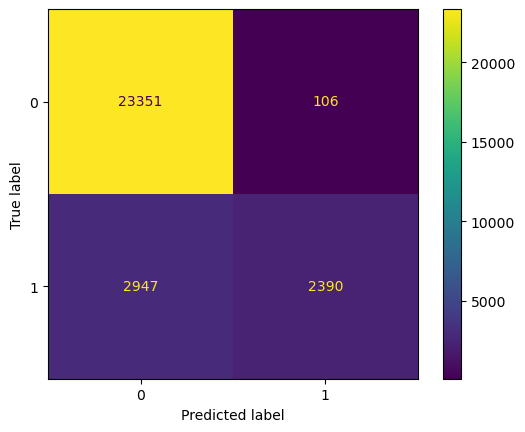

In [87]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred), display_labels=nn10.classes_).plot();

In [61]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     23457
           1       0.96      0.45      0.61      5337

    accuracy                           0.89     28794
   macro avg       0.92      0.72      0.77     28794
weighted avg       0.90      0.89      0.88     28794



See https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification.

In [55]:
1 - y.mean()

0.814634739273125

In [56]:
y_blind = np.zeros_like(y_train)
print(classification_report(y_train, y_blind))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     23457
           1       0.00      0.00      0.00      5337

    accuracy                           0.81     28794
   macro avg       0.41      0.50      0.45     28794
weighted avg       0.66      0.81      0.73     28794



/Users/wuqilong/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wuqilong/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wuqilong/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

<a id='hyper'></a>
## Grid Search for Hyperparameters

In [57]:
#nn_range= np.arange(10, 1, -1)
nn_range = np.arange(50, 5, -4)

In [2]:
np.arange(50, 5, -4)[:3]

array([50, 46, 42])

In [58]:
from sklearn.model_selection import GridSearchCV

test1 = GridSearchCV(neighbors.KNeighborsClassifier(), {'n_neighbors':nn_range[:3]}, 
                     scoring='f1', cv=5, verbose=2)

test1.fit(X_ttrain, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................n_neighbors=50; total time=   1.6s
[CV] END .....................................n_neighbors=50; total time=   1.5s
[CV] END .....................................n_neighbors=50; total time=   1.6s
[CV] END .....................................n_neighbors=50; total time=   1.5s
[CV] END .....................................n_neighbors=50; total time=   1.5s
[CV] END .....................................n_neighbors=46; total time=   1.5s
[CV] END .....................................n_neighbors=46; total time=   1.6s
[CV] END .....................................n_neighbors=46; total time=   1.5s
[CV] END .....................................n_neighbors=46; total time=   1.6s
[CV] END .....................................n_neighbors=46; total time=   1.5s
[CV] END .....................................n_neighbors=42; total time=   1.5s
[CV] END .....................................n_n

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([50, 46, 42])}, scoring='f1',
             verbose=2)

In [59]:
test1.cv_results_

{'mean_fit_time': array([0.00319262, 0.00225263, 0.00245576]),
 'std_fit_time': array([1.15474092e-03, 9.18504474e-05, 1.91127457e-04]),
 'mean_score_time': array([1.5572022 , 1.54204645, 1.6479692 ]),
 'std_score_time': array([0.03062027, 0.00737581, 0.05573453]),
 'param_n_neighbors': masked_array(data=[50, 46, 42],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 50}, {'n_neighbors': 46}, {'n_neighbors': 42}],
 'split0_test_score': array([0.5502008 , 0.54946524, 0.54849498]),
 'split1_test_score': array([0.54225828, 0.54741089, 0.54875588]),
 'split2_test_score': array([0.52897069, 0.53125   , 0.53648649]),
 'split3_test_score': array([0.54870775, 0.54533422, 0.5464191 ]),
 'split4_test_score': array([0.53243243, 0.53306343, 0.53494624]),
 'mean_test_score': array([0.54051399, 0.54130476, 0.54302054]),
 'std_test_score': array([0.00851556, 0.00760437, 0.00603825]),
 'rank_test_score': array([3, 2, 1], dtype=int

In [3]:
import os

n_cores = os.cpu_count()
print("Number of CPU cores available:", n_cores)

Number of CPU cores available: 12


In [60]:
train_scores, cv_scores = validation_curve(neighbors.KNeighborsClassifier(), X_ttrain, y_train, 
                                           param_name='n_neighbors', cv=5, n_jobs=8,
                                           param_range=nn_range, scoring='f1', verbose=2)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  60 | elapsed:  4.4min remaining:  4.4min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  8.9min finished


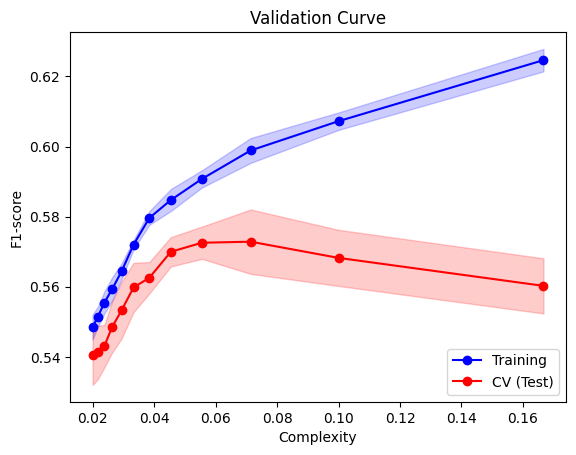

In [61]:
train_means = np.mean(train_scores, axis=1)
train_sd = np.std(train_scores, axis=1)

cv_means = np.mean(cv_scores, axis=1)
cv_sd = np.std(cv_scores, axis=1)

plt.plot(1/nn_range, train_means, 'o-', label='Training', color='blue')
plt.fill_between(1/nn_range, train_means-train_sd, train_means+train_sd, color='blue', alpha=0.2)

plt.plot(1/nn_range, cv_means, 'o-', label='CV (Test)', color='red')
plt.fill_between(1/nn_range, cv_means-cv_sd, cv_means+cv_sd, color='red', alpha=0.2)

plt.legend(loc='lower right');plt.ylabel('F1-score');plt.xlabel('Complexity');plt.title('Validation Curve');

In [88]:
X_ttrain.shape

(28794, 105)

## ROC Curves and Precision-Recall Curves

In [65]:
nn20 = neighbors.KNeighborsClassifier(n_neighbors=20, n_jobs=8)
nn20.fit(X_ttrain, y_train)

KNeighborsClassifier(n_jobs=8, n_neighbors=20)

In [66]:
y_test_probs = nn20.predict_proba(X_ttest)

In [89]:
y_test_probs

array([[0.85, 0.15],
       [0.9 , 0.1 ],
       [0.85, 0.15],
       ...,
       [0.6 , 0.4 ],
       [0.8 , 0.2 ],
       [0.65, 0.35]])

In [80]:
len(y_test_probs)

12341

In [68]:
y_test_pred = nn20.predict(X_ttest)

In [69]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     10053
           1       0.94      0.42      0.58      2288

    accuracy                           0.89     12341
   macro avg       0.91      0.71      0.76     12341
weighted avg       0.89      0.89      0.87     12341



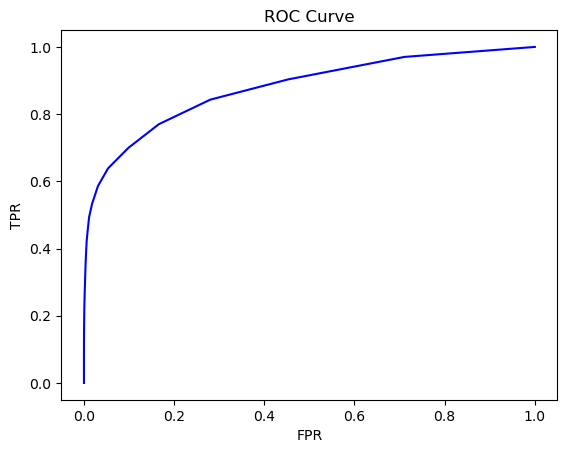

In [72]:
fpr, tpr, threshold = roc_curve(y_test, y_test_probs[:, 1])

plt.plot(fpr, tpr,'b-');
plt.title('ROC Curve')
plt.xlabel('FPR');plt.ylabel('TPR');

In [73]:
print(f'The area under the AUC is {auc(fpr, tpr):.3f}.')

The area under the AUC is 0.878.


In [74]:
nn_precision, nn_recall, thresholds = precision_recall_curve(y_test, y_test_probs[:, 1])

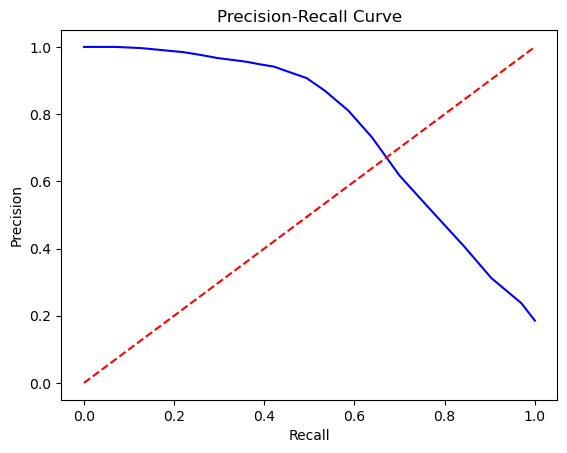

In [75]:
plt.plot(nn_recall, nn_precision,'b-');
plt.title('Precision-Recall Curve')
plt.xlabel('Recall');plt.ylabel('Precision');
plt.plot([0.0, 1.0], [0.0, 1.0], color='red', linestyle="--");

In [76]:
pd.DataFrame({'prec':nn_precision[1:], 'rec':nn_recall[1:], 'thresh':thresholds})

,prec,rec,thresh
0,0.237002,0.970280,0.00
1,0.312141,0.903409,0.05
2,0.406448,0.843094,0.10
3,0.513254,0.770105,0.15
4,0.616628,0.700175,0.20
5,0.731231,0.638549,0.25
6,0.810762,0.586101,0.30
7,0.870278,0.533654,0.35
8,0.907556,0.493444,0.40
9,0.926589,0.452360,0.45


<a id='ref'></a>
# 6. References
<a href=#top>(back to top)</a>

1. [Introduction to statistical learning](https://www.statlearning.com/) This is one of the most complete introductory books on the topic.
2. [scikit-learn docs](https://scikit-learn.org/stable/user_guide.html)
3. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems By Aurélien Géron (electronic copy available at NUS libraries)
4. Introduction to Data Science A Python Approach to Concepts, Techniques and Applications by Laura Igual (electronic version available at NUS libraries)